In [1]:
# !pip install torch===1.6.0 torchvision===0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

In [2]:
import numpy as np
from PIL import Image
import torch
from torch import nn
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [4]:
class CartPoleDataset(Dataset):
  def __init__(self, data, transform=None):
    super().__init__()
    self.data = data
    self.transform = transform

  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, index):
    image, label = self.data[index]
    image = np.asarray(image)
    if self.transform != None:
      image = self.transform(image)

    return image, label

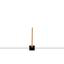

In [5]:
img = Image.open("cart2.jpg")
img = img.resize((64, 64), Image.ANTIALIAS)

data = [[img, 1]]

img

In [6]:
batch_size = 1

transform = transforms.Compose([transforms.ToTensor(),])

cart_pole_dataset = CartPoleDataset(data, transform=transform)
data_loader = DataLoader(dataset=cart_pole_dataset, batch_size=batch_size, shuffle=True)

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/functional.py:56: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(pic.transpose((2, 0, 1)))


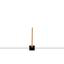

In [7]:
def tensor_to_image(x, mean=0, std=1):
  x = np.transpose(x.numpy(), (1, 2, 0))
  x = (x*std+ mean)*255
  x = x.astype(np.uint8)
  return Image.fromarray(x, 'RGB')

for batch_idx, (data, action) in enumerate(data_loader):
  data = data

data = data[0]
img = tensor_to_image(data)
img

In [8]:
class DQN(nn.Module):
  def __init__(self, h, w, outputs):
    super(DQN, self).__init__()
    self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
    self.bn1 = nn.BatchNorm2d(16)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
    self.bn2 = nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
    self.bn3 = nn.BatchNorm2d(32)

    def conv2d_size_out(size, kernel_size = 5, stride = 2):
        return (size - (kernel_size - 1) - 1) // stride  + 1

    convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
    convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
    linear_input_size = convw * convh * 32
    self.head = nn.Linear(linear_input_size, outputs)

  def forward(self, x):
    x = F.relu(self.bn1(self.conv1(x)))
    x = F.relu(self.bn2(self.conv2(x)))
    x = F.relu(self.bn3(self.conv3(x)))
    return self.head(x.view(x.size(0), -1))

In [9]:
dqn = DQN(64, 64, 2)

In [10]:
for batch_idx, (data, action) in enumerate(data_loader):
  data = data

out = dqn(data)
print(out)

tensor([[ 0.1784, -0.2744]], grad_fn=<AddmmBackward>)


In [11]:
torch.argmax(out, dim=1)

tensor([0])

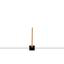

In [14]:
img